In [1]:
import os
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import resunet.utils as rutils

## Required Functions and Classes

In [2]:
# Creating a simple version of params class from resunet.utils since the 
# full configuration file is not needed.

class Params:
    def __init__(self, feat_used, target_used, outputdir):
        self.feat_used = feat_used                                              
        self.target_used = target_used                                          
        self.output_dir = outputdir
        
# Modifying the preprocess function from resunet.utils to match
# the procedure needed for proper rescaling of prediction maps.

def preprocess(params, unproc):
    stdvals = {}                                                                
    meanvals = {}
    for i in [params.feat_used, params.target_used]:                            
        for key, value in i.items():                                            
            meanvals[value+"_mean"] = np.mean(unproc[value])                    
            stdvals[value+"_std"] = np.std(unproc[value] - meanvals[value+"_mean"])
    
    os.makedirs(os.path.join(params.output_dir,"orig_info"), exist_ok=True)
    np.savez(os.path.join(params.output_dir, "orig_info/map_stds"), **stdvals) 
    np.savez(os.path.join(params.output_dir, "orig_info/map_means"), **meanvals) 
                                                                                  
    for i in [params.feat_used, params.target_used]:                            
        for key, value in i.items():                                            
            unproc[value] = (unproc[value] - meanvals[value+"_mean"]) / stdvals[value+"_std"]
                                                                                  
    for key, value in unproc.items():                                           
        unproc[key] = np.reshape(unproc[key], (value.shape[0], 128, 128, 1))    
    return unproc

## Defining Variables

In [3]:
features = {"qlen": "q_len", "ulen":"u_len"}
targets = {"unle":"e_unl", "tau": "tru_tau", "kappa":"tru_kappa"}

# where to save files
output_dir = "noiseless_predictions"

# path to data if using a .npz file.
data_path = "../data/example_dataset/map_sets32.npz"

params = Params(features, targets, output_dir)
os.makedirs(params.output_dir, exist_ok=True)

The key parameter in the features and targets dictionaries should be identical to those used in the
configuration file for training. Those are set when training the model and cannot be changed without
retraining.

The values in the dictionaries are the names of the arrays of CMB maps you will use. Throughout this notebook I will use the naming convention from the datapipe.py file. However, if you create your own array of maps, the names of those arrays can be anything as long as you remain consistent throughout this notebook.

## Beginning Process to Make Predictions

In [4]:
# Loading data from a .npz file where each array represents a CMB map type.
# This step can be skipped if you already have arrays of maps.

named_arrays_to_load = ["q_len", "u_len"] + ["e_unl", "tru_tau", "tru_kappa"]
unprocessed_data = rutils.load_data(data_path, named_arrays_to_load)

# You must also use noiseless data with the noiseless network.

---
#### IMPORTANT NOTE
##### If the map has a 'len' in the name, it is the observed CMB map. It is a map that has been modulated by patchy reionization and then lensed. It also includes noise and a taper as described in our paper. If the map has a "unl" in the name, it is the primordial CMB map with taper applied.

##### Also, while only the two input maps, observed Q and U, are required to make predictions, this notebook will assume you also have the truth maps you wish to compare the ResUNet-CMB predictions to,

---

The previous code cell creates a dictionary with 5 entries. Each key in the dictionary indicates the type of map contained within the array, which is the value.

For example,

<class 'numpy.ndarray'>
(10, 128, 128)


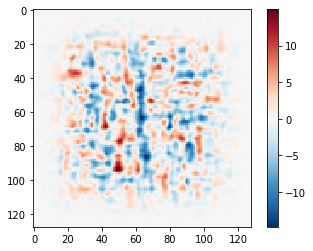

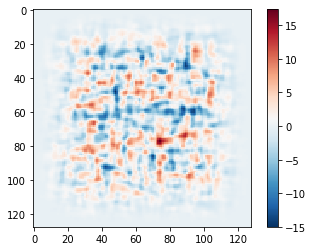

In [5]:
q_len_maps = unprocessed_data["q_len"]
print(type(q_len_maps))
print(q_len_maps.shape)

plt.imshow(q_len_maps[0], cmap="RdBu_r")
plt.colorbar()
plt.show()

plt.imshow(q_len_maps[1], cmap="RdBu_r")
plt.colorbar()
plt.show()

q_len_maps is a numpy array with 10 individual maps that are 128 $\times$ 128 pixels. 

---

If you already have arrays of maps you wish to make predictions with, put them in a dictionary with the keys being recognizable names you create and the values the array of maps.

For example:
    
    custom_unprocessed_data = {}
    observed_Q_maps = np.array([...])
    observed_U_maps = np.array([...])
    
    true_E_maps = np.array([...])
    true_kappa_maps = np.array([...])
    true_tau_maps = np.array([...])
    
    custom_unprocessed_data["custom_Q_maps"] = observed_Q_maps
    custom_unprocessed_data["custom_U_maps"] = observed_U_maps
    
    custom_unprocessed_data["custom_E_maps"] = true_E_maps
    custom_unprocessed_data["custom_tau_maps"] = true_tau_maps
    custom_unprocessed_data["custom_kappa_maps"] = true_kappa_maps

If the custom_unprocessed_data dictionary is defined as above, the features and targets dictionary must be changed to:
    
    features = {"qlen": "cusom_Q_maps", "ulen":"custom_U_maps"}
    targets = {"unle":"custom_E_maps", "tau": "true_tau_maps", "kappa":"true_kappa_maps"}

In [6]:
# Loading trained network
model_architecture = "noiseless_netw/model_architecture.json"
model_weights = "noiseless_netw/model_weights_noiseless.h5"
model = rutils.load_model(model_architecture, model_weights)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
qlen (InputLayer)               [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
ulen (InputLayer)               [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 2)  0           qlen[0][0]                       
                                                                 ulen[0][0]                       
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3264        concatenate[0][0]            

In [7]:
# Processing data
processed_data = preprocess(params, unprocessed_data)

The data is now in the same format as that which was used during training. Let's take a look at what the maps now look like.

<class 'numpy.ndarray'>
(10, 128, 128, 1)


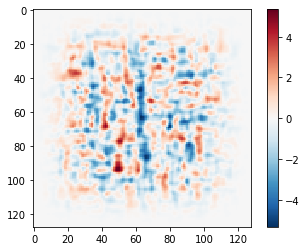

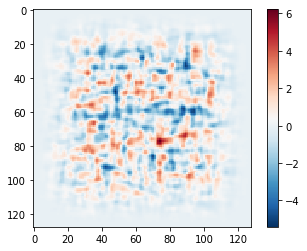

In [8]:
processed_q_len_maps = processed_data["q_len"]
print(type(processed_q_len_maps))
print(processed_q_len_maps.shape)

# There is now another axis in the tensor. The images now need to
# be reshaped before plotting.

plt.imshow(np.reshape(processed_q_len_maps[0], (128,128)), cmap="RdBu_r")
plt.colorbar()
plt.show()

plt.imshow(np.reshape(processed_q_len_maps[1], (128,128)), cmap="RdBu_r")
plt.colorbar()
plt.show()

When comparing the preprocessed and unprocessed maps it is now clear that the images remain the same while only the scale changes.

---

### Reminder:
The ResUNet-CMB model has set name labels for input and output tensors that must be used.

##### Input Tensor Names:
###### "qlen" and "ulen"
##### Output Tensor Names:
###### "kappa", "tau", and "unle"

These names can only be changed by retraining the model and altering the appropriate variables in the configuration file. Specifically, the key values in the dictionary for feat_used and target_used.

In [9]:
# creating a new dictionary with the tensor names as the
#keys and the values set to the corresponding array of maps.

x_input = {}
for key, value in params.feat_used.items():
    x_input[key] = processed_data[value]
    print("{}, {}".format(key, value))

# Saving the truth data for the three output maps. Predictions will
# be compared to these.
print("\nTruth maps:")
truth_dic = {}
for key, value in params.target_used.items():
    truth_dic[value] = unprocessed_data[value]
    print(value)

qlen, q_len
ulen, u_len

Truth maps:
e_unl
tru_tau
tru_kappa


In [10]:
# With the input dictionary ready, we can now make the predictions.
prediction_map_arr = model.predict(x_input, batch_size=32, verbose=1)
datadic = {key.name.split('/')[0] + '_pred': prediction_map_arr[i] for i, key in enumerate(model.outputs)}

for key, value in datadic.items():
    print(key)

10/10 [==============================] - 3s 257ms/sample
tau_pred
unle_pred
kappa_pred


## Inspecting Predictions

Now that we have the predictions we can compare them to the truth maps to see how well the network performs.

### IMPORTANT NOTE:
### The map_means and map_stds files included with the pre-trained network are the values from the training set as mentioned in our paper. These are the values that should be used to rescale the predictions the network makes.
### The map_means and map_stds files saved into orig_info are used to scale the TRUTH maps only.

### Noiseless $\tau$ Prediction

Truth Map


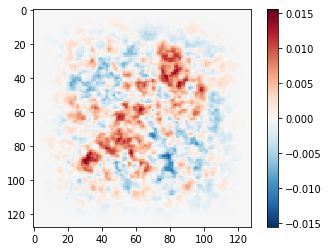

Prediction Map


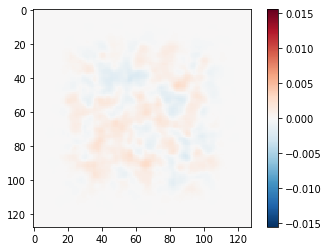

In [11]:
# Tau Predictions

# Since the model was trained on standardized data, the predictions are also standardized. First we need to
# rescale the maps.

map_number = 9

# To rescale the truth maps we use the map_means and map_stds from the orig_info directory.
truth_tau_mean = rutils.load_data(
    os.path.join(params.output_dir,"orig_info/map_means.npz"), ["tru_tau_mean"])["tru_tau_mean"]

truth_tau_std = rutils.load_data(
    os.path.join(params.output_dir,"orig_info/map_stds.npz"), ["tru_tau_std"])["tru_tau_std"]

rescaled_truth_tau = (np.reshape(truth_dic["tru_tau"][map_number], (128,128)) * truth_tau_std) + truth_tau_mean 

# To rescale the prediction maps we use the map_means and map_stds from the trained model data set since we
# do not have a priori knowledge of the true observed maps.
pred_tau_mean = rutils.load_data(
    "noiseless_netw/map_means.npz", ["tru_tau_mean"])["tru_tau_mean"]

pred_tau_std = rutils.load_data(
    "noiseless_netw/map_stds.npz", ["tru_tau_std"])["tru_tau_std"]

rescaled_pred_tau = (np.reshape(datadic["tau_pred"][map_number], (128,128)) * pred_tau_std) + pred_tau_mean

print("Truth Map")
plt.imshow(rescaled_truth_tau, cmap="RdBu_r", vmin=-np.max(rescaled_truth_tau), vmax=np.max(rescaled_truth_tau))
plt.colorbar()
plt.show()

print("Prediction Map")
plt.imshow(rescaled_pred_tau, cmap="RdBu_r", vmin=-np.max(rescaled_truth_tau), vmax=np.max(rescaled_truth_tau))
plt.colorbar()
plt.show()

### Noiseless $\kappa$ Prediction

Truth Map


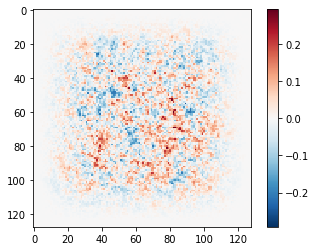

Prediction Map


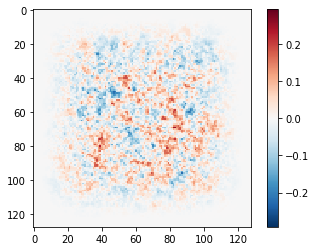

In [12]:
# Kappa Predictions

# Since the model was trained on standardized data, the predictions are also standardized. First we need to
# rescale the maps.

map_number = 9

# To rescale the truth maps we use the map_means and map_stds from the orig_info directory.
truth_kappa_mean = rutils.load_data(
    os.path.join(params.output_dir,"orig_info/map_means.npz"), ["tru_kappa_mean"])["tru_kappa_mean"]

truth_kappa_std = rutils.load_data(
    os.path.join(params.output_dir,"orig_info/map_stds.npz"), ["tru_kappa_std"])["tru_kappa_std"]

rescaled_truth_kappa = (np.reshape(truth_dic["tru_kappa"][map_number], (128,128)) * truth_kappa_std) + truth_kappa_mean 

# To rescale the prediction maps we use the map_means and map_stds from the trained model data set since we
# do not have a priori knowledge of the true observed maps.
pred_kappa_mean = rutils.load_data(
    "noiseless_netw/map_means.npz", ["tru_kappa_mean"])["tru_kappa_mean"]

pred_kappa_std = rutils.load_data(
    "noiseless_netw/map_stds.npz", ["tru_kappa_std"])["tru_kappa_std"]

rescaled_pred_kappa = (np.reshape(datadic["kappa_pred"][map_number], (128,128)) * pred_kappa_std) + pred_kappa_mean

print("Truth Map")
plt.imshow(rescaled_truth_kappa, cmap="RdBu_r", vmin=-np.max(rescaled_truth_kappa), vmax=np.max(rescaled_truth_kappa))
plt.colorbar()
plt.show()

print("Prediction Map")
plt.imshow(rescaled_pred_kappa, cmap="RdBu_r", vmin=-np.max(rescaled_truth_kappa), vmax=np.max(rescaled_truth_kappa))
plt.colorbar()
plt.show()

Truth Map


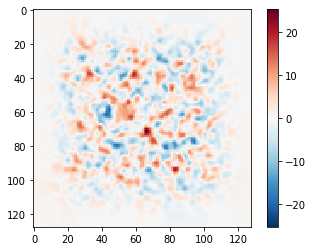

Prediction Map


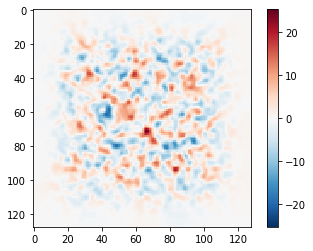

In [13]:
# Primordial E Predictions

# Since the model was trained on standardized data, the predictions are also standardized. First we need to
# rescale the maps.

map_number = 9

# To rescale the truth maps we use the map_means and map_stds from the orig_info directory.
truth_E_mean = rutils.load_data(
    os.path.join(params.output_dir,"orig_info/map_means.npz"), ["e_unl_mean"])["e_unl_mean"]

truth_E_std = rutils.load_data(
    os.path.join(params.output_dir,"orig_info/map_stds.npz"), ["e_unl_std"])["e_unl_std"]

rescaled_truth_E = (np.reshape(truth_dic["e_unl"][map_number], (128,128)) * truth_E_std) + truth_E_mean 

# To rescale the prediction maps we use the map_means and map_stds from the trained model data set since we
# do not have a priori knowledge of the true observed maps.
pred_E_mean = rutils.load_data(
    "noiseless_netw/map_means.npz", ["e_unl_mean"])["e_unl_mean"]

pred_E_std = rutils.load_data(
    "noiseless_netw/map_stds.npz", ["e_unl_std"])["e_unl_std"]

rescaled_pred_E = (np.reshape(datadic["unle_pred"][map_number], (128,128)) * pred_E_std) + pred_E_mean

print("Truth Map")
plt.imshow(rescaled_truth_E, cmap="RdBu_r", vmin=-np.max(rescaled_truth_E), vmax=np.max(rescaled_truth_E))
plt.colorbar()
plt.show()

print("Prediction Map")
plt.imshow(rescaled_pred_E, cmap="RdBu_r", vmin=-np.max(rescaled_truth_E), vmax=np.max(rescaled_truth_E))
plt.colorbar()
plt.show()